In [1]:
from __future__ import print_function

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imutils.paths import list_images
from keras import backend as K
from keras.callbacks import CSVLogger
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from scipy.io import loadmat
from scipy.misc import imread
from skimage.io import imsave
from skimage.transform import resize

from datasetutils.bsds500 import BSDS500

target_size = (256, 256)

warnings.filterwarnings('ignore')
%matplotlib inline

Using TensorFlow backend.


In [2]:
K.set_image_data_format('channels_last') 



def get_unet(img_rows, img_cols, channels):
    inputs = Input((img_rows, img_cols, channels))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    
    
    model.compile(optimizer=Adam(lr=1e-3), 
                      loss='binary_crossentropy',
                      metrics=['binary_crossentropy'])


    return model

In [4]:
from datasetutils.bsds500 import BSDS500
TARGET_SHAPE = (256, 256)

bsds = BSDS500(target_size=TARGET_SHAPE)
ids, contours_train, sgmnts, train_images = bsds.get_train()
ids, contours_test, sgmnts, test_images = bsds.get_train()

C = np.concatenate([contours_test, contours_train])
I = np.concatenate([test_images, train_images])

csv_callback = CSVLogger('history.log', append=True)
unet = get_unet(256, 256, 3)
history = unet.fit(I, C, verbose=2, epochs=200, validation_split=0.1, callbacks=[csv_callback])

/home/i008/BSR


In [29]:
csv_callback = CSVLogger('history.log', append=True)
unet = get_unet(256, 256, 3)
H = unet.fit(I, C, verbose=2, epochs=200, validation_split=0.1, callbacks=[csv_callback])

# unet = load_model('unet.keras')
# save_model(unet, 'unet2.keras')

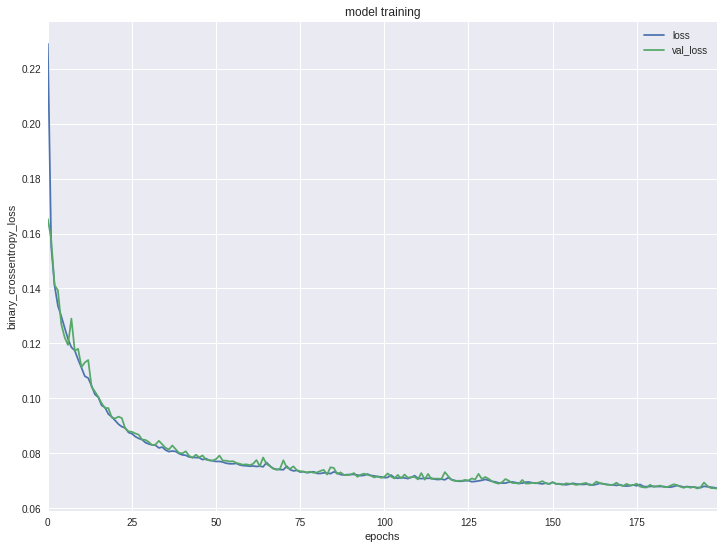

In [28]:
import seaborn
f = pd.DataFrame(H.history)[['loss','val_loss']].plot(figsize=(12,9))
plt.title('model training')
plt.ylabel('binary_crossentropy_loss')
plt.xlabel('epochs')